In [16]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import time

In [17]:
import warnings
warnings.filterwarnings("ignore")

# Load data

In [18]:
save_address = 'C:/Users/xi-lucy.chen/Documents/GitLab/data_challenge_alc_total/phase_2_Lucy/feature/'
wp1 = pd.read_csv(save_address+'wp1.csv')
wp2 = pd.read_csv(save_address+'wp2.csv')
wp3 = pd.read_csv(save_address+'wp3.csv')
wp4 = pd.read_csv(save_address+'wp4.csv')
wp5 = pd.read_csv(save_address+'wp5.csv')
wp6 = pd.read_csv(save_address+'wp6.csv')


In [19]:
for wp in [wp1,wp2,wp3,wp4,wp5,wp6]:
    wp.index = wp['date']
    wp.drop(columns='date',inplace=True)

In [20]:
wp1[0:2]

,wp1,train,u,v,ws,wd,Day sin,Day cos,Year sin,Year cos,...,expanding_mean_u_2,expanding_mean_v_2,expanding_mean_ws_2,expanding_mean_wd_2,expanding_mean_u_3,expanding_mean_v_3,expanding_mean_ws_3,expanding_mean_wd_3,Yearday_sin,Yearday_cos
date,,,,,,,,,,,,,,,,,,,,,
2009-07-01 00:00:00,0.051,1.0,3.14,-3.62,4.79,139.09,0.866025,0.500000,0.015690,-0.999877,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013588,-0.499938
2009-07-01 01:00:00,0.051,1.0,3.14,-3.62,4.79,139.09,0.965926,0.258819,0.014973,-0.999888,...,3.14,-3.62,4.79,139.09,NaN,NaN,NaN,NaN,0.014463,-0.258790


In [21]:
def get_X(df):
    return df.iloc[:, 1:]

def get_y(df, name='wp1'):
    return df[name]

def get_X_test(df):
    return df.iloc[:, 0:]


def data_test_split(df, model_address, start_date="2009-07-01 00:00:00", end_date="2010-12-31 23:00:00", name='wp1'):
    '''
    resplit data & test from full data
    '''
    train = df[df['train'] == 1].sort_values(by='date')
    test = df[df['train'] != 1].sort_values(by='date')
    train = train.drop(columns=['train'])
    test = test.drop(columns=['train', name])
    train = train.loc[start_date:end_date]
    train.to_csv(model_address+'training_data_{}.csv'.format(name))
    X_train = get_X(train)
    y_train = get_y(train, name)
    X_forecast = get_X_test(test)
    return X_train, y_train, X_forecast ,test # train, test,


# Data Split

In [22]:
from sklearn.model_selection import train_test_split


def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=177)
    return X_train, X_test, y_train, y_test


# XGBOOST

In [23]:
tune_parameter = False
grid_search = False



params = {'colsample_bytree': 0.8,
           'max_depth': 6,
#           'min_child_weight': 9,
#           'eval_metric': 'mae',
#           'subsample': 0.9,
#           'colsample': 1,
           'eta': 0.01}

params={}
params['gpu_id'] = 1
#params['max_bin'] = 32
params['tree_method'] = 'gpu_hist'


num_boost_round = 10000


# FORECAST

In [24]:
def prediction(X_forecast, test, model, name):
    X_forecast = xgb.DMatrix(data=X_forecast)
    df_predictions = pd.DataFrame({
        'date': test.index,
        name: model.predict(X_forecast),
    })
    save_address = 'C:/Users/xi-lucy.chen/Documents/GitLab/data_challenge_alc_total/phase 2 model/Lucy/result/'
    df_predictions.to_csv(save_address+"pred_{}.csv".format(name))
    return df_predictions


# Additional Feature

In [25]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()


def kMeansRes(scaled_data, k, alpha_k=0.02):
    inertia_o = np.square((scaled_data - scaled_data.mean(axis=0))).sum()
    # fit k-means
    kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_data)
    scaled_inertia = kmeans.inertia_ / inertia_o + alpha_k * k
    return scaled_inertia


def chooseBestKforKMeans(scaled_data, k_range):
    ans = []
    for k in k_range:
        scaled_inertia = kMeansRes(scaled_data, k)
        ans.append((k, scaled_inertia))
    results = pd.DataFrame(ans, columns=['k', 'Scaled Inertia']).set_index('k')
    best_k = results.idxmin()[0]
    return best_k, results

def i_want_graph(results):
    plt.figure(figsize=(7, 4))
    plt.plot(results, 'o')
    plt.title('Adjusted Inertia for each K')
    plt.xlabel('K')
    plt.ylabel('Adjusted Inertia')
    plt.xticks(range(1, 10, 1))
    plt.show()

def add_cluster(train,test):

    k_range = range(1, 10)

    best_k, results = chooseBestKforKMeans(mms.fit_transform(
        train[['u', 'v', 'ws', 'wd']]), k_range)
    print('ok..my best k is ...',best_k)

    #i_want_graph(results)

    #print("hey, i override my best_k")
    #best_k = 4
    
    kmeans = KMeans(n_clusters=best_k, random_state=77).fit(mms.fit_transform(
        train[['u', 'v', 'ws', 'wd']]))
    array1 = kmeans.labels_
    array2=kmeans.predict(mms.fit_transform(test[['u', 'v', 'ws', 'wd']]))
    
    array1=array1.tolist()
    array2=array2.tolist()

    train['my_cluster'] = pd.Series(array1, index=train.index)
    test['my_cluster'] = pd.Series(array2, index=test.index)
    return train, test


In [26]:
def create_dummy(data, col):
    data = pd.get_dummies(data, columns=[col])
    return data


# RUNNNNNN

wp1 ...my X length is... 18480 ...my y length is... 18480
my X length is.. 36960 , my y length is.. 36960
my_X_forecast length is.. 14880 , my_test length is.. 14880
my X length is.. 55440 , my y length is.. 55440
my_X_forecast length is.. 22320 , my_test length is.. 22320
my X length is.. 73920 , my y length is.. 73920
my_X_forecast length is.. 29760 , my_test length is.. 29760
my X length is.. 92400 , my y length is.. 92400
my_X_forecast length is.. 37200 , my_test length is.. 37200
my X length is.. 110880 , my y length is.. 110880
my_X_forecast length is.. 44640 , my_test length is.. 44640
ok..my best k is ... 7
run model now
Baseline MAE is 0.24
[17:29:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	Test-rmse:0.27805
[1]	Test-rmse:0.22422
[2]	Test-rmse:0.19112
[3]	Test-rmse:0.17071
[4]	Test-rmse:0.15848
[5]	Test-rmse:0.15103
[6]	Test-rmse:0.14645
[7]	Test-rmse:0.14349
[8]	Test-rmse:0.14

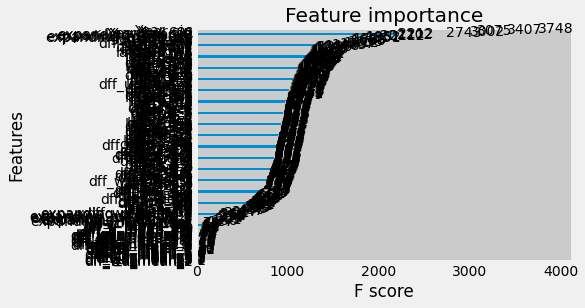

model finished now.. 22.78 min


In [27]:
#from pandas.io.json import json_normalize
import model3_gpu
import xgboost as xgb
from datetime import date
import json
import gc
#param_list = pd.DataFrame()
prediction = pd.DataFrame()
start_date = "2009-07-01 00:00:00"
end_date = "2010-12-31 23:00:00"

save_address = 'C:/Users/xi-lucy.chen/Documents/GitLab/data_challenge_alc_total/phase_2_Lucy/result/'
model_address = 'C:/Users/xi-lucy.chen/Documents/GitLab/data_challenge_alc_total/phase_2_Lucy/model/'
months_predict = [
                # '201101', 
                # '201102', 
                # '201103',
                # '201104',
                # '201105',
                # '201106',
                # '201107',
                # '201108',
                # '201109',
                # '201110',
                # '201111',
                # '201112',
                # '201201',
                # '201202',
                # '201203',
                # '201204',
                # '201205',
                '201206']
train_end_date = [
                # "2010-12-31 23:00:00",
                # "2011-01-31 23:00:00",
                # "2011-02-28 23:00:00",
                # "2011-03-31 23:00:00",
                # "2011-04-30 23:00:00",
                # "2011-05-30 23:00:00",
                # "2011-06-30 23:00:00",
                # "2011-07-31 23:00:00",
                # "2011-08-31 23:00:00",
                # "2011-09-30 23:00:00",
                # "2011-10-31 23:00:00",  
                # "2011-11-30 23:00:00",
                # "2011-12-31 23:00:00",
                # "2012-01-31 23:00:00",
                # "2012-02-29 23:00:00",
                # "2012-03-31 23:00:00",
                # "2012-04-30 23:00:00",
                "2012-05-31 23:00:00"]

for year, end_date in zip(months_predict, train_end_date):
    # for name,df in zip(["wp1", "wp2", "wp3", "wp4", "wp5", "wp6"],[wp1,wp2,wp3,wp4,wp5,wp6]):
    #     print('------ name is :', name, "------")
    #     #split my merged dataset
    #     X, y, X_forecast,test = data_test_split(df, model_address=model_address, start_date=start_date, end_date=end_date, name=name)
    #     #split to train model
    #     '''we do the modification here'''
    for name_1, df_1 in zip(["wp1", "wp2", "wp3", "wp4", "wp5", "wp6"], [wp1, wp2, wp3, wp4, wp5, wp6]):
            X_temp, y_temp, X_forecast_temp,test_temp = data_test_split(
                df_1, model_address=model_address, start_date=start_date, end_date=end_date, name=name_1)
            test_temp['wp'] = name_1
            if name_1 == 'wp1':
                X_temp['wp'] = name_1
                X_forecast_temp['wp'] = name_1
                my_X = X_temp
                my_y = y_temp
                my_X_forecast = X_forecast_temp
                my_test =test_temp
                print(name_1,'...my X length is...', len(my_X), '...my y length is...', len(my_y))
            else:
                X_temp['wp'] = name_1
                X_forecast_temp['wp'] = name_1
                my_X = my_X.append(X_temp)
                my_y = my_y.append(y_temp)
                my_X_forecast = my_X_forecast.append(X_forecast_temp)
                my_test = my_test.append(test_temp)
                print('my X length is..', len(my_X),', my y length is..', len(my_y))
                print('my_X_forecast length is..', len(my_X_forecast), ', my_test length is..', len(my_test))
                del X_temp, y_temp, X_forecast_temp, test_temp
                gc.collect()

    X = my_X
    y = my_y
    X_forecast = my_X_forecast
    test=my_test
    ''''''
    #ADDING FEATURE after merged dataset

    X = create_dummy(X, 'wp')
    X_forecast = create_dummy(X_forecast, 'wp')
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_forecast.replace([np.inf, -np.inf], np.nan, inplace=True)
    X=X.fillna(X.mean())
    X_forecast = X_forecast.fillna(X_forecast.mean())

    #BUG: I don't know why, but normalization is a BAD BAD IDEA! 
    #print('My X null is...', X.isnull().sum().sum(), ', and my max is ',X.max().max())
    #X = scale_features(X, scaler='MinMaxScaler')
    #X_forecast = scale_features(X_forecast, scaler='MinMaxScaler')

    #print(os.getcwd())
    #X.to_csv('what is going on.csv')

    X, X_forecast = add_cluster(X, X_forecast)

    temp_data_path = 'C:/Users/xi-lucy.chen/Documents/GitLab/data_challenge_alc_total/phase_2_Lucy/data/intermediate validation/'
    if year== '201206':
        X.to_csv(temp_data_path+"X_{}.csv".format(year),index=False)
        X_forecast.to_csv(temp_data_path+"X_forecast_{}.csv".format(year),index=False)
    ''''''
    X_train, X_test, y_train, y_test = split_data(X,y)

    print('run model now')
    ts = time.time()
    model,param = xgboost_gpu.run_xgb(X_train, X_test, y_train, y_test, params = params,num_boost_round=num_boost_round,
                                 tune_parameter=False, grid_search=False, graph=True)                      
    
    te = time.time()                             
    print('model finished now..',"%2.2f min" % ( (te - ts) / 60))
    '''
    Forecast
    '''
    X_forecast = xgb.DMatrix(data=X_forecast)
    df_predictions = pd.DataFrame({
            'date': test.index,
            'wp':test['wp'],
            "forecast": model.predict(X_forecast),
        })
    model.save_model(model_address+"model_merged_train_{}.json".format(year))
        #df_predictions.to_csv(save_address+"pred_{}.csv".format(name))
        #print(param)
        #print(type(param)) #This is string type
        #param = json.loads(param)
    with open(model_address+"param_merged_train_{}.json".format(year), 'w') as f:
            json.dump(param, f)
        #param_list = param_list.append(param)
    # if name =='wp1':
    #         prediction = df_predictions
    #     else:
    #         prediction = prediction.merge(df_predictions,on=['date'])
    prediction= pd.pivot_table(df_predictions, index=df_predictions.index,
                   columns='wp', values='forecast', aggfunc=min).reset_index()

    prediction.rename(columns={'date': 'date1'}, inplace=True)
    data_path = 'C:/Users/xi-lucy.chen/Documents/GitLab/data_challenge_alc_total/data/'
    test = pd.read_csv(f'{data_path}test.csv')
    prediction = pd.concat([test, prediction], axis=1)
    prediction.drop(columns='date1', inplace=True)

    save_address = 'C:/Users/xi-lucy.chen/Documents/GitLab/data_challenge_alc_total/phase_2_Lucy/result/before_submission/'
    prediction.to_csv(
    save_address+'gpu_predictions_end_date_{}.csv'.format(year), index=False, sep=';')


In [ ]:
#comment GPU model is super fast, but performance seems less good than cpu

In [28]:
def read_folder(file_folder):
    """
        Read all files in the folder
        """
    files = os.listdir(file_folder)
    df = []
    for f in files:
        print(f)
        my_file = file_folder + "/" + f
        temp = pd.read_csv(my_file, sep=';')
        temp['file_name']=f
        df.append(temp)
    df_full = pd.concat(df, ignore_index=True)
    return df_full


In [29]:
df_full = read_folder(
    "C:/Users/xi-lucy.chen/Documents/GitLab/data_challenge_alc_total/phase_2_Lucy/result/before_submission/")

gpu_predictions_end_date_201206.csv
predictions_end_date_201206.csv


In [30]:
df_full['file_forecast_month'] = df_full['file_name'].str[21:27]
df_full['forecast_month'] = df_full['date'].astype(str).str[0:6]

df_full['match'] = np.where(df_full['file_forecast_month']
                       == df_full['forecast_month'],True,False)
df_full=df_full[df_full['match']==True]
prediction = df_full.drop(
    columns=['file_forecast_month', 'match', 'file_name', 'forecast_month'])
save_address2 = 'C:/Users/xi-lucy.chen/Documents/GitLab/data_challenge_alc_total/phase_2_Lucy/result/submission/'
prediction.to_csv(
    save_address2+'predictions_{}.csv'.format(date.today()), index=False, sep=';')


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/xi-lucy.chen/Documents/GitLab/data_challenge_alc_total/phase_2_Lucy/result/submission/predictions_2021-10-03.csv'

# Merge predictions

read_address = 'C:/Users/xi-lucy.chen/Documents/GitLab/data_challenge_alc_total/phase 2 model/Lucy/result/'
pred_wp1=pd.read_csv(read_address+"pred_wp1.csv")
pred_wp2=pd.read_csv(read_address+"pred_wp2.csv")
pred_wp3=pd.read_csv(read_address+"pred_wp3.csv")
pred_wp4=pd.read_csv(read_address+"pred_wp4.csv")
pred_wp5=pd.read_csv(read_address+"pred_wp5.csv")
pred_wp6=pd.read_csv(read_address+"pred_wp6.csv")

In [ ]:
# read_address = 'C:/Users/xi-lucy.chen/Documents/GitLab/data_challenge_alc_total/phase 2 model/Lucy/result/'
# save_address = 'C:/Users/xi-lucy.chen/Documents/GitLab/data_challenge_alc_total/phase 2 model/Lucy/result/submission/'
# pred1=pd.read_csv(read_address+'pred_wp1.csv')
# pred2=pd.read_csv(read_address+'pred_wp2.csv')
# pred3=pd.read_csv(read_address+'pred_wp3.csv')
# pred4=pd.read_csv(read_address+'pred_wp4.csv')
# pred5=pd.read_csv(read_address+'pred_wp5.csv')
# pred6 = pd.read_csv(read_address+'pred_wp6.csv')

# merge_pred=pd.DataFrame()
# merge_pred=pred1
# merge_pred = merge_pred.merge(pred2,on='date')
# merge_pred = merge_pred.merge(pred3,on='date')
# merge_pred = merge_pred.merge(pred4,on='date')
# merge_pred = merge_pred.merge(pred5,on='date')
# merge_pred = merge_pred.merge(pred6,on='date')


# merge_pred.to_csv('predictions.csv', index=False, sep=';')
# df_predictions.head()


In [ ]:
import json
model_address = 'C:/Users/xi-lucy.chen/Documents/GitLab/data_challenge_alc_total/phase_2_Lucy/model/'
def read_my_json(model_address,my_file):
    f = open(model_address+my_file)
    json_file = json.load(f)
    return json_file


param1 = json.loads(read_my_json(
    model_address, 'param_merged_train_201205.json'))
param2 = json.loads(read_my_json(
    model_address, 'param_merged_train_201206.json'))
# param3 = json.loads(read_my_json(
#     model_address, 'param_merged_train 201103.json'))
# param4 = json.loads(read_my_json(
#     model_address, 'param_merged_train 201104.json'))
# param5 = json.loads(read_my_json(
#     model_address, 'param_merged_train 201105.json'))
# param6 = json.loads(read_my_json(
#     model_address, 'param_merged_train 201106.json'))


In [ ]:
df = pd.json_normalize(param1)
df=df.append(pd.json_normalize(param2))
df=df.append(pd.json_normalize(param3))
# df=df.append(pd.json_normalize(param4))
# df=df.append(pd.json_normalize(param5))
# df = df.append(pd.json_normalize(param6))
df=df.reset_index(drop=True)
df.to_csv(model_address + 'my_tuned_params_combined.csv')


NameError: name 'param3' is not defined